<a href="https://colab.research.google.com/github/fastdatascience/clinical_trial_risk/blob/fixes_nov_2022/train/ctgov/TrainPhaseAndArmAndNumSubjectsClassifier_09_Spacy_with_config_continuing_from_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TODO: make config without transformers

1.   List item
2.   List item



In [ ]:
#!pip install spacy-transformers

In [ ]:
# !python -m spacy init fill-config base_config.cfg spacy_textcat_06.cfg

In [ ]:
import pandas as pd
import re
import os
import sys
import pickle as pkl
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import json

# df_annotations = pd.read_csv("all_annotations.csv")


# Get data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_annotations= pd.read_csv("/content/drive/MyDrive/data/filtered_for_phase_arms_subjects_02.csv.bz2")

In [ ]:
#df_annotations= pd.read_csv("filtered_for_phase_arms_subjects_02.csv.bz2")
# df_annotations= pd.read_csv("/home/thomas/Downloads/filtered_for_phase_arms_subjects.csv.bz2")

In [ ]:
#df_annotations.text = df_annotations.text.apply(lambda t : t[:10000] if len(t) > 10000 else t)

In [ ]:
def get_num_subjects_clean(num):
    if pd.isna(num):
        return None
    if num >= 10000:
        return "10000+"
    if num >= 1000:
        return "1000+"
    if num >= 500:
        return "500+"
    if num >= 200:
        return "200+"
    if num >= 100:
        return "100+"
    if num >= 50:
        return "50+"
    if num >= 25:
        return "25+"
    return "1-24"
df_annotations["num_subjects_clean"] = df_annotations["num_subjects"].apply(get_num_subjects_clean)

In [ ]:
df_annotations["num_subjects_clean"].value_counts()

1-24      2980
25+       2119
50+       2016
100+      1674
200+      1656
500+       816
1000+      547
10000+     112
Name: num_subjects_clean, dtype: int64

In [ ]:
# df_annotations = pd.read_csv("filtered_for_phase.csv.bz2")

In [ ]:
# del file_to_pages

In [ ]:
phase_map = {"Phase 2":"2",
"Phase 3":"3",
"Phase 4":"4",
"Phase 1":"1",
"Phase 1/Phase 2":"1.5",
"Not Applicable":"0",
"Phase 2/Phase 3":"2.5",
"Early Phase 1":"0.5"}
df_annotations["phase_clean"] = df_annotations["phase"].apply(lambda x : phase_map.get(x, None))

In [ ]:
phase_clean_map = {}
for idx, val in enumerate(sorted(set(phase_map.values()), key = lambda x : float(x))):
  phase_clean_map[val] = idx
# invert the dictionary
phase_lookup = {v: k for k, v in phase_clean_map.items()}

phase_list = [phase_lookup[x] for x in sorted(phase_lookup)]
phase_list

['0', '0.5', '1', '1.5', '2', '2.5', '3', '4']

In [ ]:
def get_num_arms_clean(num):
    if pd.isna(num):
        return None
    if num >= 5:
        num = 5
    return num
df_annotations["num_arms_clean"] = df_annotations["num_arms"].apply(get_num_arms_clean)

# Begin Spacy

In [ ]:
num_subjects_clean_map = {}
for idx, val in enumerate(sorted(set(df_annotations[~df_annotations.num_subjects_clean.isna()].num_subjects_clean), key = lambda x : int(re.sub(r'\D.*$', '', x)))):
  num_subjects_clean_map[val] = idx

In [ ]:
# invert the dictionary
num_subjects_lookup = {v: k for k, v in num_subjects_clean_map.items()}

In [ ]:
num_subjects_list = [num_subjects_lookup[x] for x in sorted(num_subjects_lookup)]
num_subjects_list

['1-24', '25+', '50+', '100+', '200+', '500+', '1000+', '10000+']

In [ ]:
num_subjects_clean_map

{'1-24': 0,
 '25+': 1,
 '50+': 2,
 '100+': 3,
 '200+': 4,
 '500+': 5,
 '1000+': 6,
 '10000+': 7}

In [ ]:
def get_one_hot_num_subjects(x):
  a = [0] * len(num_subjects_clean_map)
  if x is None:
    return a
  a[num_subjects_clean_map[x]] = 1
  return a

In [ ]:
df_annotations["num_subjects_one_hot"] = df_annotations["num_subjects_clean"].apply(get_one_hot_num_subjects)

In [ ]:
df_annotations["num_subjects_one_hot"] = df_annotations["num_subjects_clean"].apply(get_one_hot_num_subjects)

In [ ]:
def get_one_hot_num_arms(x):
  a = [0] * 5
  if x is not None and not pd.isna(x):
    a[int(x - 1)] = 1
  return a
df_annotations["num_arms_one_hot"] = df_annotations["num_arms_clean"].apply(get_one_hot_num_arms)

In [ ]:
def get_one_hot_phase(x):
  a = [0] * len(phase_clean_map)
  if x is None:
    return a
  a[phase_clean_map[x]] = 1
  return a
df_annotations["phase_one_hot"] = df_annotations["phase_clean"].apply(get_one_hot_phase)

Concatenate the three bits of one-hot data into one column

In [ ]:
concatenated_one_hot = []
for i in range(len(df_annotations)):
  concatenated = list(df_annotations.phase_one_hot.iloc[i]) + \
  list(df_annotations.num_arms_one_hot.iloc[i]) + \
  list(df_annotations.num_subjects_one_hot.iloc[i]) + [df_annotations.has_sap.iloc[i]]
  concatenated_one_hot.append(concatenated)
df_annotations["concatenated_one_hot"] = concatenated_one_hot

In [ ]:
np.sum(np.asarray([np.asarray(x) for x in df_annotations["concatenated_one_hot"]]), axis=1).mean()

nan

In [ ]:
np.sum(np.asarray([np.asarray(x) for x in df_annotations["concatenated_one_hot"]]), axis=0)

array([ 519.,  135., 1154.,  983., 4317.,  297., 2725., 1461., 3086.,
       5228., 1456.,  908.,  913., 2980., 2119., 2016., 1674., 1656.,
        816.,  547.,  112.,   nan])

In [ ]:
num_classes = len(concatenated)
print (f"There are {num_classes} classes in this multi-label classifier")

There are 22 classes in this multi-label classifier


In [ ]:
df_train = df_annotations[df_annotations.train_val == "train"]
df_val = df_annotations[df_annotations.train_val == "val"]

In [ ]:
df_train_got_some_ground_truths = df_train[~df_train.num_subjects_clean.isna() | ~df_train.num_arms_clean.isna() | ~df_train.phase_clean.isna()]

In [ ]:
len(df_train_got_some_ground_truths), len(df_train)

(9535, 9538)

# Begin Spacy

In [ ]:
# TRAINING_DATA = [
#     ["My little kitty is so special", {"KAT0": True}],
#     ["Dude, Totally, Yeah, Video Games", {"KAT1": True}],
#     ["Should I pay $1,000 for the iPhone X?", {"KAT1": True}],
#     ["The iPhone 8 reviews are here", {"KAT1": True}],
#     ["Noa is a great cat name.", {"KAT0": True}],
#     ["We got a new kitten!", {"KAT0": True}]
# ]

# TRAINING_DATA = []
# for idx in range(len(df_train)):
#     cats = {}
#     for a in range(num_classes):
#         cats[str(a)] = df_annotations["concatenated_one_hot"].iloc[idx][a]

#     text = df_train.text.iloc[idx]
#     if len(text) > 1000000:
#         text = text[:1000000]
    
#     TRAINING_DATA.append([text , cats])

## Preprocess everything into two DocBins so that we can train from the command line with spaCy

In [ ]:
import spacy

nlp = spacy.blank("en")
from spacy.tokens import DocBin

docs_train = []
for i in range(10):
  docs_train.append(DocBin())
docs_val = DocBin()

for idx in range(len(df_annotations)):
  if idx % 100 == 0:
    print (idx, len(df_annotations))
  if df_annotations.train_val.iloc[idx] == "train":
    docs_list = docs_train[idx % 10]
  else:
    docs_list = docs_val
  text = str(df_annotations.text.iloc[idx])
  if len(text) > 100000:
      text = text[:100000]
  doc = nlp(text)

  cats = {}
  for a in range(num_classes):
        cats[str(a)] = df_annotations["concatenated_one_hot"].iloc[idx][a]
  doc.cats = cats

  docs_list.add(doc)

0 11926
100 11926
200 11926
300 11926
400 11926
500 11926
600 11926
700 11926
800 11926
900 11926
1000 11926
1100 11926
1200 11926
1300 11926
1400 11926
1500 11926
1600 11926
1700 11926
1800 11926
1900 11926
2000 11926
2100 11926
2200 11926
2300 11926
2400 11926
2500 11926
2600 11926
2700 11926
2800 11926
2900 11926
3000 11926
3100 11926
3200 11926
3300 11926
3400 11926
3500 11926
3600 11926
3700 11926
3800 11926
3900 11926
4000 11926
4100 11926
4200 11926
4300 11926
4400 11926
4500 11926
4600 11926
4700 11926
4800 11926
4900 11926
5000 11926
5100 11926
5200 11926
5300 11926
5400 11926
5500 11926
5600 11926
5700 11926
5800 11926
5900 11926
6000 11926
6100 11926
6200 11926
6300 11926
6400 11926
6500 11926
6600 11926
6700 11926
6800 11926
6900 11926
7000 11926
7100 11926
7200 11926
7300 11926
7400 11926
7500 11926
7600 11926
7700 11926
7800 11926
7900 11926
8000 11926
8100 11926
8200 11926
8300 11926
8400 11926
8500 11926
8600 11926
8700 11926
8800 11926
8900 11926
9000 11926
9100 11926


In [ ]:
# docs_train.to_disk("train.spacy")
docs_val.to_disk("dev.spacy")

In [ ]:
docs_val.to_disk("/content/drive/MyDrive/data/dev.spacy")

In [ ]:
# !mkdir train.spacy
# !mkdir /content/drive/MyDrive/data/train.spacy


mkdir: cannot create directory ‘/content/drive/MyDrive/data/train.spacy’: File exists


In [ ]:
for idx, doc_bin_train in enumerate(docs_train):
  doc_bin_train.to_disk(f"train.spacy/train_doc_bin{idx}.spacy")
  doc_bin_train.to_disk(f"/content/drive/MyDrive/data/train.spacy/train_doc_bin{idx}.spacy")

# Begin training using spaCy CLI

In [48]:
!python -m spacy train ./spacy_textcat_09.cfg --output /content/drive/MyDrive/data/output_textcat_06 --paths.train /content/drive/MyDrive/data/train.spacy --paths.dev /content/drive/MyDrive/data/dev.spacy --gpu-id 0

ℹ Saving to output directory:
/content/drive/MyDrive/data/output_textcat_06
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
[2022-11-15 07:01:52,122] [INFO] Set up nlp object from config
INFO:spacy:Set up nlp object from config
[2022-11-15 07:01:52,134] [INFO] Pipeline: ['textcat_multilabel']
INFO:spacy:Pipeline: ['textcat_multilabel']
[2022-11-15 07:01:52,138] [INFO] Created vocabulary
INFO:spacy:Created vocabulary
[2022-11-15 07:01:52,139] [INFO] Finished initializing nlp object
INFO:spacy:Finished initializing nlp object
tcmalloc: large alloc 1073750016 bytes == 0x129ae2000 @  0x7f9a992e02a4 0x58ead6 0x441ff3 0x5d1f81 0x5d2306 0x58f62c 0x5105e2 0x58fd37 0x50ca37 0x58fd37 0x50ca37 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4d00fb 0x7f9911c9c7c6 0x4ba72b 0x7f9911c9ace3 0x58f6e4 0x50ff13 0x5b575e 0x4bad0a 0x4d3249 0x591e56 0x50e18c 0x5b575e 0x58ff2e 0x50d482 0x5b575e 0x58ff2e
[2022-11-15 07:09:58,151] [INFO] Initialized pipeline components: ['te

In [ ]:
1

In [62]:
import spacy
nlp = spacy.load("/content/drive/MyDrive/data/output_textcat_06/model-best")

In [63]:
predictions = []
for idx in range(len(df_val)):
    doc = nlp(df_val.text.apply(str).iloc[idx])
    predictions.append(doc.cats)

In [64]:
pred_proba = []
for idx in range(len(df_val)):
    pred_proba.append([predictions[idx][str(a)] for a in range(num_classes)])

In [65]:
y_pred_phase = []
y_pred_num_arms = []
y_pred_num_subjects = []
y_pred_sap = []
for idx in range(len(pred_proba)):
  probas_this_instance = pred_proba[idx]
  probas_phase = probas_this_instance[:len(phase_lookup)]
  y_pred_phase.append(phase_lookup[int(np.argmax(probas_phase))])
  probas_arms = probas_this_instance[len(phase_lookup):len(phase_lookup)+5]
  y_pred_num_arms.append(1 + int(np.argmax(probas_arms)))
  probas_subjects = probas_this_instance[len(phase_lookup)+5:-1]
  y_pred_num_subjects.append(num_subjects_lookup[int(np.argmax(probas_subjects))])
  probas_sap = probas_this_instance[-1:]
  y_pred_sap.append(probas_sap[0] > 0.5)

df_val["y_pred_phase"] = y_pred_phase
df_val["y_pred_num_arms"] = y_pred_num_arms
df_val["y_pred_num_subjects"] = y_pred_num_subjects
df_val["y_pred_sap"] = y_pred_sap

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

## Phase

In [66]:
acc = accuracy_score(df_val.phase_clean.apply(str), df_val["y_pred_phase"])
print (f"Phase accuracy {acc}")

Phase accuracy 0.44423963133640554


''

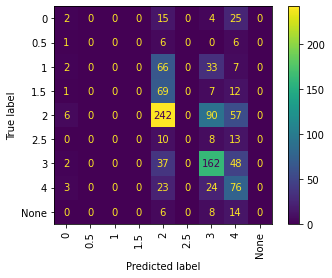

In [67]:
ConfusionMatrixDisplay.from_predictions(df_val.phase_clean.apply(str), df_val["y_pred_phase"])
plt.xticks(rotation=90)
;

# Number of arms

In [68]:
acc = accuracy_score(df_val.num_arms_clean.apply(float).apply(str), df_val["y_pred_num_arms"].apply(float).apply(str))
print (f"Num arms accuracy {acc}")

Num arms accuracy 0.576036866359447


''

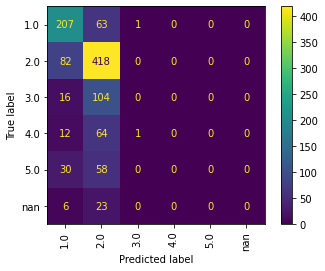

In [69]:
ConfusionMatrixDisplay.from_predictions(df_val.num_arms_clean.apply(float).apply(str), df_val["y_pred_num_arms"].apply(float).apply(str))
plt.xticks(rotation=90)
;

## Subjects

In [70]:
acc = accuracy_score(df_val.num_subjects_clean, df_val["y_pred_num_subjects"])
print (f"Subjects accuracy {acc}")

Subjects accuracy 0.2709677419354839


''

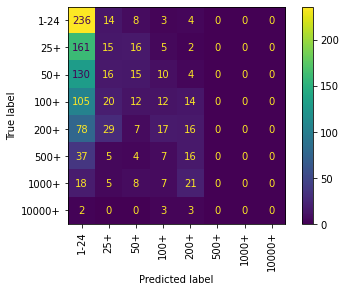

In [71]:
ConfusionMatrixDisplay.from_predictions(df_val.num_subjects_clean, df_val["y_pred_num_subjects"], labels=num_subjects_list)
plt.xticks(rotation=90)
;

In [72]:
num_correct = 0
for idx in range(len(df_val)):
  gt = num_subjects_clean_map[df_val["num_subjects_clean"].iloc[idx]]
  pred = num_subjects_clean_map[df_val["y_pred_num_subjects"].iloc[idx]]
  is_correct = int(np.abs(gt - pred) <= 1)
  num_correct += is_correct
print ("Accuracy including adjacent groups", num_correct/len(df_val))

Accuracy including adjacent groups 0.5253456221198156


## SAP

In [73]:
acc = accuracy_score(df_val.has_sap, df_val["y_pred_sap"])
print (f"SAP accuracy {acc}")

SAP accuracy 0.8055299539170507


''

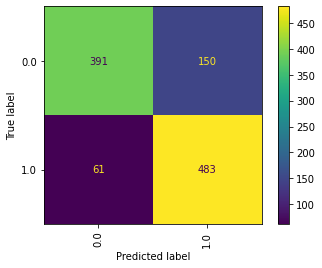

In [74]:
ConfusionMatrixDisplay.from_predictions(df_val.has_sap, df_val["y_pred_sap"])
plt.xticks(rotation=90)
;